# BL EThOS
#### Katriona Goldmann, November 2022

---

# Intro

The British Library operates its [Electronic Theses Online Service](https://ethos.bl.uk) or EThOS, that keeps track of PhD theses accepted at UK higher education institutions. The Library also makes public a [data set](https://data.bl.uk/ethos/) of metadata for all theses in their catalogue. Quoting their website,

>The EThOS dataset lists virtually all UK doctoral theses ever awarded, some 500,000 dating back to 1787. All UK HE institutions are included, but we estimate records are missing for around 10,000 titles (2%).

The latest version of the dataset is from October 2022. The data includes the title, year, author, institution, discipline for each thesis, as well as a link to a full record which may or may not include things like keywords or access to full texts.

---

## Analysis goals and outline 

In this notebook I explore this EThOS dataset to identify gender trends in UK academia. The notebook is structured roughly as follows:
- [x] Prepare the data for analysis

#### Gender analysis
- [x] Predict the gender of authors from their first name
- [ ] Predict supervisor genders

#### Supervisor network
- [ ] Create a network of supervision - how inter/intra-institutional are the networks? 

#### Buzz words
- [ ] Study trends in the popularities of individual words appearing in thesis titles
- [ ] Use a co-occurrence graph of words in thesis titles to detect academic fields, and score thesis titles on which field(s) they seem to belong to
- [ ] Use the above to study trends in the popularity of different academic fields

---

# 0. Setting up and preparing the data

## 0.1 Load in the data and import packages

First off, some imports of python libraries we'll be needing, and loading the data file into a pandas DataFrame. The script will automatically download the data file into the current working directory if it isn't there yet.

In [1]:
import os
import operator as opr
import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx
import re
import gender_guesser.detector as gender
import community  # Network community finding
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go



from IPython.display import set_matplotlib_formats

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]

# Set a consistent plotting style across the notebook using Seaborn.
sns.set_style("darkgrid")
sns.set_context("notebook")

Get the data from EThOS. The latest one which isn't embargoed in 202210. 

In [3]:
# Function to clean the NaN and incorrectly formatted data
def remove_na(df: pd.DataFrame, save: bool = True,
              filename: str = "Data/EThOS_CSV_202210.csv") -> pd.DataFrame:
    null_df = df[df["IR URL"].isnull()]
    for index, row in null_df.iterrows():
        new_row = []
        # Title
        new_row.append(row["Title"].split(",")[0])
        # DOI
        new_row.append(row["Title"].split(",")[1])
        # Author
        first_name = row["Title"].split(",")[2]
        second_name = row["DOI"][:-1]
        new_row.append(first_name + second_name)
        # Remaining columns
        colnames = [col for col in df.columns
                    if col not in ["Title", "DOI", "IR URL"]]
        new_row += row[colnames].tolist()
        df.loc[index] = new_row
    df = df.fillna(' ')
    if save:
        df.to_csv(f"cleaned_{filename}")
    return 

In [4]:
datafile = "EThOS_CSV_202304.csv"

print('../Data/' + datafile)

import os
os.getcwd()

../Data/EThOS_CSV_202304.csv


'/Users/kgoldmann/Documents/Projects/TDS/TuringDataStories_Ethos/stories/2023-09-29-EThOS/notebooks'

In [5]:
# Check if file not already downloaded
if not os.path.isfile('../Data/' + datafile):
    # Download and/or unzip the data file from the EThOS website.
    # We need a couple more imports for this.
    import zipfile

    datazip = re.sub("csv", "zip", datafile)
    if not os.path.isfile('../Data/' + datazip):
        import requests

        dataurl = "https://bl.iro.bl.uk/downloads/6c6aab6d-a8e1-4ed7-85e2-7963d2569f80?locale=en"
        with requests.Session() as s:
            headers = {
                "User-agent": "Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0"
            }
            r = s.get(dataurl, headers=headers)
            with open('../Data/' + datazip, "wb") as f:
                f.write(r.content)
    with zipfile.ZipFile('../Data/' + datazip, "r") as z:
        z.extractall(".")

In [6]:
df = pd.read_csv(f"../Data/cleaned_{datafile}", encoding="ISO-8859-2")

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_64396/1458184179.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"../Data/cleaned_{datafile}", encoding="ISO-8859-2")


## 0.2 Inspect the data

To get an idea of what the rows in the DataFrame look like, here are some samples:

In [7]:
df.head()

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
0,0,Computation and measurement of turbulent flow ...,,"Loizou, Panos A.",https://isni.org/isni/0000000136122593,,University of Manchester,https://isni.org/isni/0000000121662407,1989,Thesis (Ph.D.),,Physical Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
1,1,Prolactin and growth hormone secretion in norm...,,"Prescott, R. W. G.",https://isni.org/isni/0000000134992122,,University of Newcastle upon Tyne,https://isni.org/isni/0000000104627212,1983,Thesis (Ph.D.),,Biological Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
2,2,Influence of strain fields on flame propagation,,"Mendes-Lopes, J. M. C.",https://isni.org/isni/0000000133937105,,University of Cambridge,https://isni.org/isni/0000000121885934,1983,Thesis (Ph.D.),Flame propagation can be highly influenced by ...,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
3,3,"Connectivity, flow and transport in network mo...",,"Robinson, Peter Clive",https://isni.org/isni/0000000135292822,,University of Oxford,https://isni.org/isni/0000000419368948,1984,Thesis (Ph.D.),In order to evaluate the safety of radioactive...,Physical Sciences,"Rae, John",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://ora.ox.ac.uk/objects/uuid:c61bf73b-b794...
4,4,The theory and implementation of a high qualit...,,"Lower, K. N.",https://isni.org/isni/0000000136133567,,University of Bristol,https://isni.org/isni/0000000419367603,1985,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,


How many entries are we dealing with?: 

In [8]:
set(df['Qualification'])

{' ',
 '2 vols: Thesis (M.D.)',
 '3 vols: Thesis (M.D.)',
 'D Clin Psy',
 'Thesis ( (Ph.D.)',
 'Thesis ( LL.D.)',
 'Thesis ( Ph.D.)',
 'Thesis ( Psy.D.)',
 'Thesis ( Psych.D.)',
 'Thesis ((Ph.D.)',
 'Thesis (Ap.Ed.Ch.Psy.D.)',
 'Thesis (Ap.Ed.Child.Psy.D.)',
 'Thesis (App.Ed.C.Psy.D.)',
 'Thesis (App.Ed.Psy.D.)',
 'Thesis (App.Psych.D.)',
 'Thesis (Arts D.)',
 'Thesis (B.Litt.)',
 'Thesis (B.Sc.)',
 'Thesis (Child Psy.D.)',
 'Thesis (Clin.D.)',
 'Thesis (Clin.Psy.D.)',
 'Thesis (Clin.Psych.D.)',
 'Thesis (D Mus.)',
 'Thesis (D. Art)',
 'Thesis (D. B. A.)',
 'Thesis (D. Eng.)',
 'Thesis (D. Fine Art)',
 'Thesis (D. Gov.)',
 'Thesis (D. Health Care)',
 'Thesis (D. Health Psy.)',
 'Thesis (D. Health Psych.)',
 'Thesis (D. Health Soc. Care)',
 'Thesis (D. Healthcare)',
 'Thesis (D. Legal)',
 'Thesis (D. Nurs.)',
 'Thesis (D. Nursing)',
 'Thesis (D. Psychoanalytic Psychotherapy)',
 'Thesis (D. Tourism)',
 'Thesis (D.A.H.P.)',
 'Thesis (D.Agri.Food)',
 'Thesis (D.App.Ch.Psy.)',
 'Thesis (D.A

In [9]:
print(df.shape[0])

627042


Data is loaded...so let's query it and search for the ETHoS contributors:

In [12]:

df.loc[df['Author'].str.contains('|'.join(['Fenton, I', 'Hauru, M', 'Goldmann, K', 'Chan, Ryan', 'Nanni, F', 'Beavan, D', 'Rangel Smith, C']))]

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
476345,476345,Environmental controls on planktonic foraminif...,https://doi.org/10.25560/53930,"Fenton, Isabel",https://isni.org/isni/0000000464226869,,Imperial College London,https://isni.org/isni/0000000121889740,2016,Thesis (Ph.D.),Planktonic foraminifera are unicellular zoopla...,Biological Sciences,"Purvis, Andy",Natural Environmental Research Council,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://doi.org/10.25560/53930


Most team members either completed doctorates too recently, or outside the UK.

---

#  1. Author Gender Analysis

## 1.1 Extract author names

In [14]:
# Oragnise names into surname, first name and forenames
df['Surname'] = df.apply(lambda row : row['Author'].split(",")[0].strip(), axis = 1)
df['Forenames'] = df.apply(lambda row : re.sub(".*,", "", str(row['Author'])), axis = 1)
df['Firstname'] = df.apply(lambda row : row['Forenames'].strip().split(" ")[0].strip(), axis = 1)

In [17]:
df[['Author', 'Surname', 'Firstname', 'Forenames']].head(10)

,Author,Surname,Firstname,Forenames
0,"Loizou, Panos A.",Loizou,Panos,Panos A.
1,"Prescott, R. W. G.",Prescott,R.,R. W. G.
2,"Mendes-Lopes, J. M. C.",Mendes-Lopes,J.,J. M. C.
3,"Robinson, Peter Clive",Robinson,Peter,Peter Clive
4,"Lower, K. N.",Lower,K.,K. N.
5,"Davenport, W. J.",Davenport,W.,W. J.
6,"Brown, T. A.",Brown,T.,T. A.
7,"Midoun, A.",Midoun,A.,A.
8,"Wu, C. M. L.",Wu,C.,C. M. L.
9,"Ismail, K. S.",Ismail,K.,K. S.


## 1.1 Predict gender from first name

We will use [gender-guesser](https://pypi.org/project/gender-guesser/) to predict an individuals gender from their first name. This can match data for about 40,000 Names from a database.

Lets test is out on two names we know the gender for, and with a couple of different spellings to really test the system:

In [20]:
gd = gender.Detector()

list_of_names = [['Katriona', 'Katrina', 'Catriona', 'Caitriona','Catarina', 'Caterina', 'Catrina'], 
                 ['Isabel', 'Isabelle', 'Isobel'],
                ['Ryan']]

print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[0]]), '\n-----')
print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[1]]), '\n-----')
print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[2]]))

Katriona is classed female
Katrina is classed female
Catriona is classed female
Caitriona is classed unknown
Catarina is classed female
Caterina is classed female
Catrina is classed female 
-----
Isabel is classed female
Isabelle is classed female
Isobel is classed female 
-----
Ryan is classed mostly_male


In this case it works pretty well - just issues with unusual spellings. 

In [52]:
df['Predicted_gender'] = df.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)

# replace andy with androgenous in Predicted gender
df['Predicted_gender'] = df['Predicted_gender'].replace({'andy': 'androgynous'})

df['Predicted_gender'] = df['Predicted_gender'].str.capitalize()

gender_count = df.Predicted_gender.value_counts()
print(gender_count)

Predicted_gender
Male             253613
Unknown          177022
Female           165292
Androgynous       14696
Mostly_female      8570
Mostly_male        7849
Name: count, dtype: int64


Visualise these predictions

In [73]:
colours = {'Unknown': 'grey', 
        'Androgynous': '#4CAF50', 
        'Female': '#730C6D', 
        'Male': '#F4BA3B', 
        'Mostly_female': '#ab65a7', 
        'Mostly_male': '#f5dca6', 
        'Initials': '#76b5c5'
        }




['#F4BA3B', 'grey', '#730C6D', '#4CAF50', '#ab65a7', '#f5dca6']

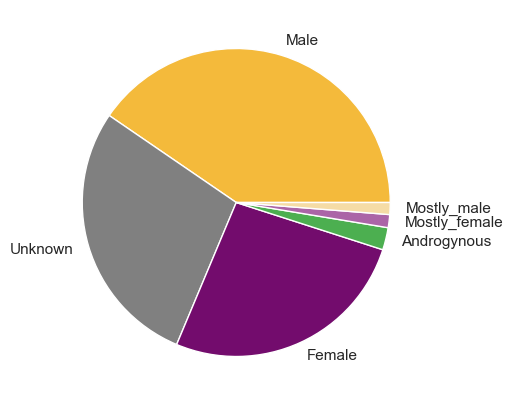

In [74]:
plt.pie(gender_count, labels = list(gender_count.index), 
        colors =[colours[key] for key in list(gender_count.index)]
)
plt.show() 

And if we repeat this but dropping initialised names? 

Predicted_gender
Male             253613
Female           165292
Unknown           80603
Androgynous       14696
Mostly_female      8570
Mostly_male        7849
Name: count, dtype: int64


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_64396/790288522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fullname['Predicted_gender'] = df_fullname.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_64396/790288522.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fullname['Predicted_gender'] = df_fullname['Predicted_gender'].replace({'andy': 'androgynous'})
/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ip

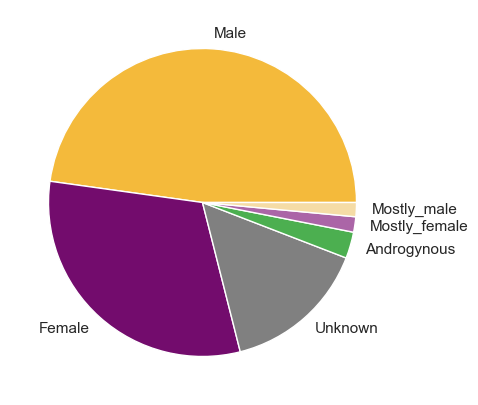

In [78]:
# Remove initialised first names
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in df['Firstname'] ]
df_fullname = df.loc[s]

# Predict gender on _this_
df_fullname['Predicted_gender'] = df_fullname.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
df_fullname['Predicted_gender'] = df_fullname['Predicted_gender'].replace({'andy': 'androgynous'})
df_fullname['Predicted_gender'] = df_fullname['Predicted_gender'].str.capitalize()

gender_count = df_fullname.Predicted_gender.value_counts()

print(gender_count)

plt.pie(gender_count, labels=list(gender_count.index),
        colors=[colours[key] for key in list(gender_count.index)]
)
plt.show() 

If we break this down into those confirmed as male and female only.  

In [79]:
df_gender = df.loc[df["Predicted_gender"].isin(["Female", "Male"])]

print('We lose', df.shape[0] - df_gender.shape[0], 'rows')

We lose 208137 rows


## 1.2 Publications by gender over time

Let's include those initialised...but as a subset of unknown. As this in itself is quite interesting - perhaps shows how authors think about gender in academia. 

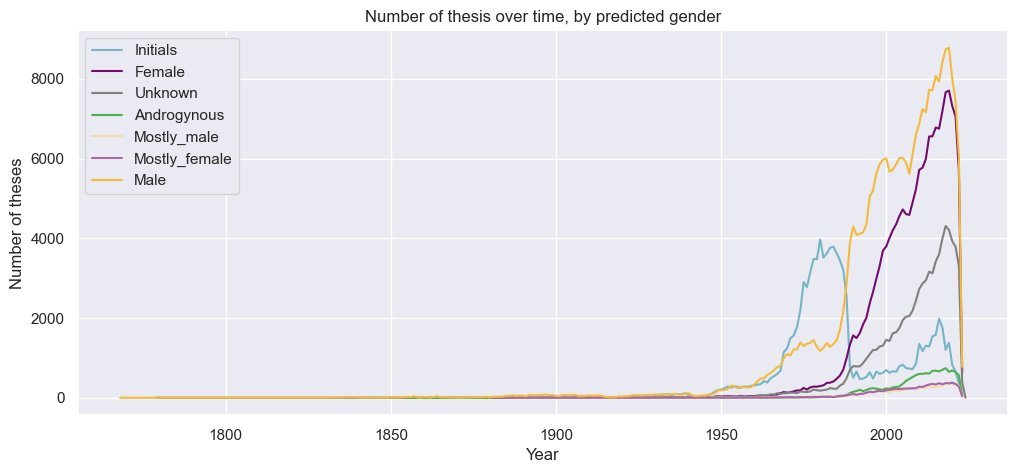

In [80]:
# Only include those with year provided
df_time = df.loc[df['Date'] != ' ']

# Label those just initialised
s = [len(re.sub("\\.", "", str(x) )) == 1 for x in df_time['Firstname'] ]
df_time.loc[s, ["Predicted_gender"]] = 'Initials'

# Loop through each gender and count number over time
for gen in set(df_time["Predicted_gender"]): 
    counts_per_year = df_time.loc[df_time["Predicted_gender"] == gen]
    counts = counts_per_year['Date'].astype(int).value_counts().sort_index()
    plt.plot(counts.index, counts, label=gen, color=colours[gen])

plt.xlabel('Year')
plt.ylabel('Number of theses')
plt.title('Number of thesis over time, by predicted gender')
plt.legend()
plt.show()


## 1.3 Gender Breakdown by Discipline

In [83]:
df2 = df_gender.loc[df["Subject Discipline"] != ' ']

all_subject = df2['Subject Discipline'].value_counts()
male = df2.loc[df2["Predicted_gender"].isin(["Male"])]['Subject Discipline'].value_counts().reindex(all_subject.index)
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(male_ratio.index)
male = male.reindex(male_ratio.index)
female = df2.loc[df2["Predicted_gender"].isin(["Female"])]['Subject Discipline'].value_counts().reindex(male_ratio.index)

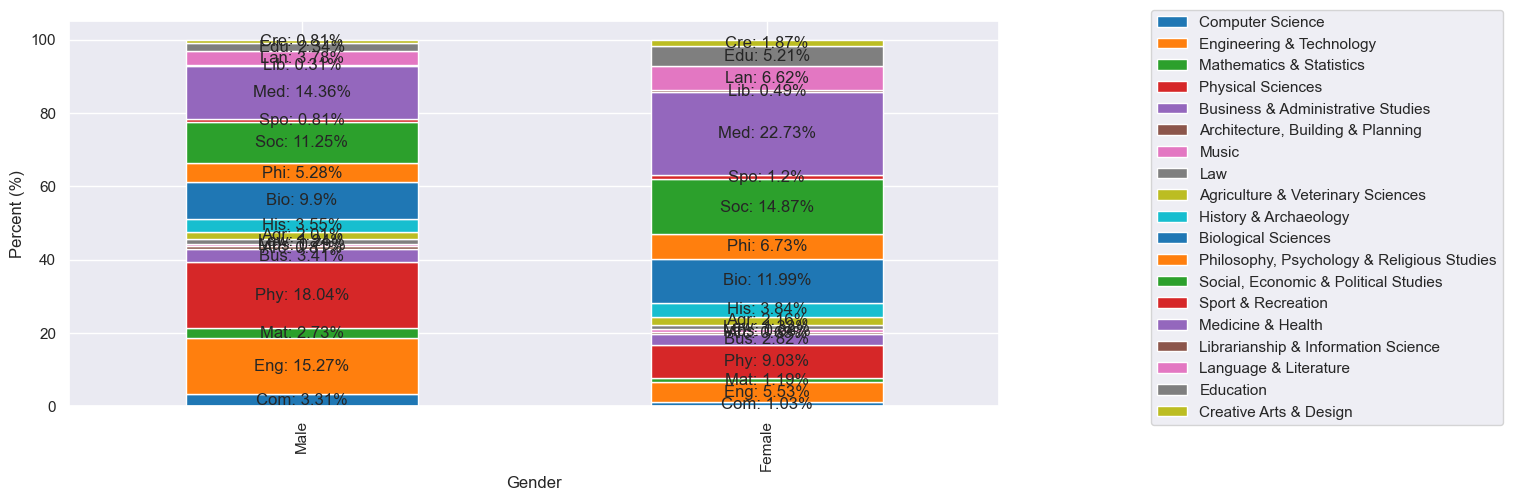

In [84]:
cols = ['Gender']
cols.extend(list(male.index))

df_discipline = pd.DataFrame(columns=cols)

m = ['Male']
m.extend(100*male.values/sum(male))
f = ['Female']
f.extend(100*female.values/sum(female))

df_discipline.loc[len(df_discipline)] = m
df_discipline.loc[len(df_discipline)] = f

ax = df_discipline.plot.bar(x='Gender', stacked='True', ylabel='Percent (%)')
ax.legend(bbox_to_anchor=(1.55, 1.05))

i=0
for c in ax.containers:
    l1 = male.index[i][0:3]
    i=i+1
    # Optional: if the segment is small or 0, customize the labels
    labels = [''.join([l1, ': ', str(round(v.get_height(), 2)) if v.get_height() > 0 else '', '%']) for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')


As I would predict, the largest proportion of female theses are in Medicine and Biology; whereas for males it in physics and engineering. 

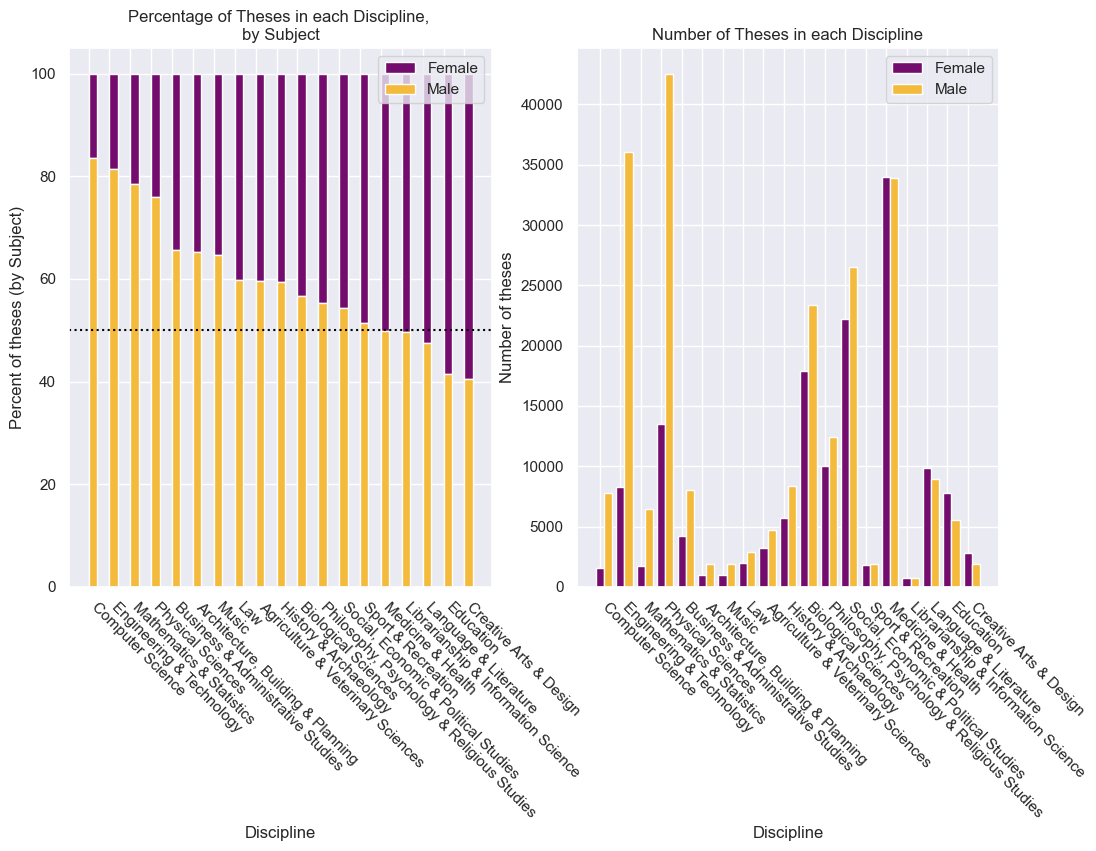

In [87]:
plt.rcParams['figure.figsize'] = [12, 7]

X_axis = np.arange(len(male))
fig, (axs1, axs2) = plt.subplots(1, 2)

# Percentages, by subject
axs1.bar(X_axis, 100*female/all_subject, 0.4, label = 'Female', bottom=100*male/all_subject, color=colours['Female'])
axs1.bar(X_axis, 100*male/all_subject, 0.4, label = 'Male', color=colours['Male'])
axs1.set_title("Percentage of Theses in each Discipline, \nby Subject")
axs1.set_xticks(X_axis-0.2, list(male.index), rotation=-45, ha='left')
axs1.axhline(y = 50, color = 'black', linestyle = ':')
axs1.set_xlabel("Discipline")
axs1.set_ylabel("Percent of theses (by Subject)")
axs1.legend()

# Raw numbers
axs2.bar(X_axis-0.2, female, 0.4, label = 'Female', color=colours['Female'])
axs2.bar(X_axis+0.2, male, 0.4, label = 'Male', color=colours['Male'])
axs2.set_xticks(X_axis-0.2, list(male.index), rotation=-45, ha='left')
axs2.set_xlabel("Discipline")
axs2.set_ylabel("Number of theses")
axs2.set_title("Number of Theses in each Discipline")
axs2.legend()

## 1.4 Gender Breakdown by Institution

In [89]:
df_inst = df_gender.loc[df["Institution"] != ' ']

all_subject = df_inst['Institution'].value_counts()
male = df_inst.loc[df_inst["Predicted_gender"].isin(["Male"])]['Institution'].value_counts().reindex(all_subject.index)
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(male_ratio.index)
male = male.reindex(male_ratio.index)
female = df_inst.loc[df_inst["Predicted_gender"].isin(["Female"])]['Institution'].value_counts().reindex(male_ratio.index)

In [90]:
s = [x for x in list(male.index) if re.search('University of Edinburgh|Queen Mary', x)]
100*male[s]/all_subject[s]

Institution
University of Edinburgh             66.646138
Queen Mary, University of London    58.340005
Name: count, dtype: float64

Let's print the worst (>65% one gender)

In [95]:
temp = male/all_subject 
matches = temp[(temp<=0.30) | (temp>=0.70)]

matches.shape

(21,)

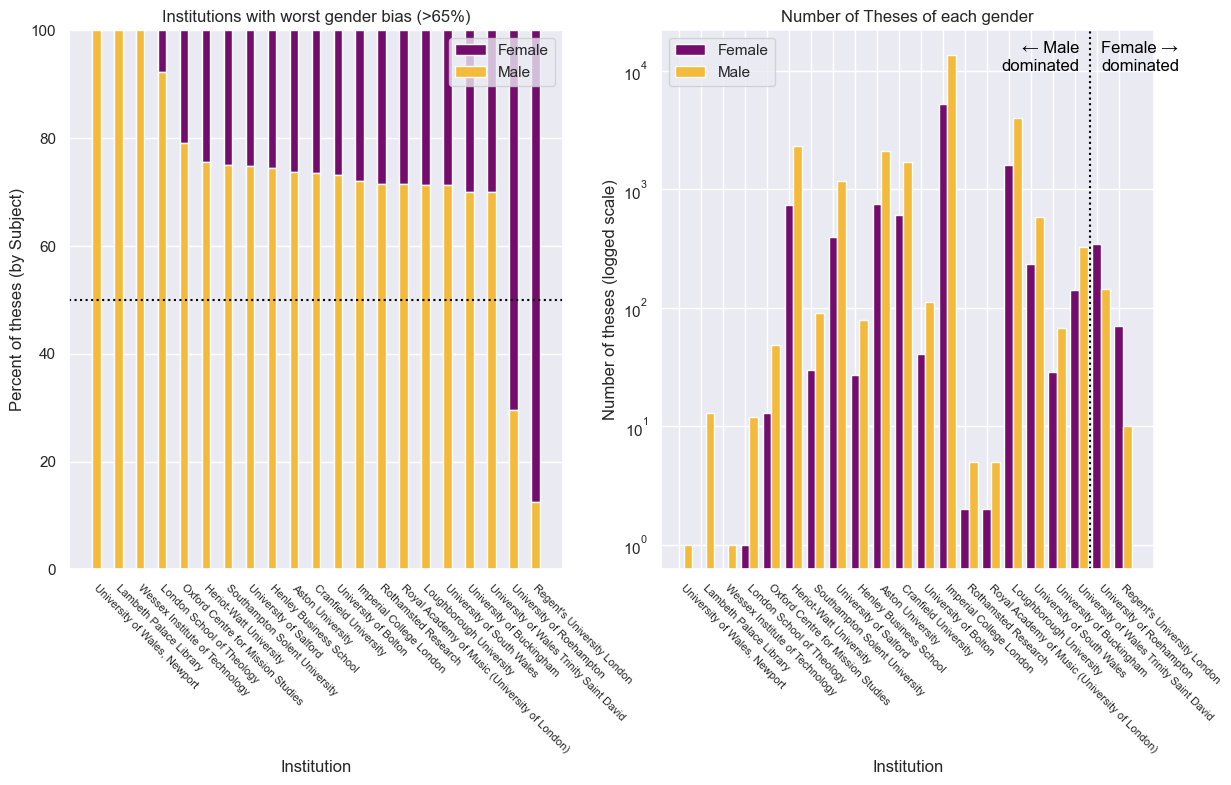

In [113]:
plt.rcParams['figure.figsize'] = [14, 7]

t1 = male[matches.index]/all_subject[matches.index]

X_axis = np.arange(len(t1))
fig, (axs1, axs2) = plt.subplots(1, 2)

# Percentage of each gender for worst offenders
axs1.bar(X_axis, 100*female[matches.index]/all_subject[matches.index], 0.4, label = 'Female', bottom=100*t1, color=colours['Female'])
axs1.bar(X_axis, 100*t1, 0.4, label = 'Male', color=colours['Male'])
axs1.set_title("Institutions with worst gender bias (>65%)")
axs1.set_xticks(X_axis-0.2, list(t1.index), rotation=-45, ha='left', size=8)
axs1.axhline(y = 50, color = 'black', linestyle = ':')
axs1.set_xlabel("Institution")
axs1.set_ylabel("Percent of theses (by Subject)")
axs1.legend()

# Raw numbers
axs2.bar(X_axis-0.2, female[matches.index], 0.4, label = 'Female', color=colours['Female'])
axs2.bar(X_axis+0.2, male[matches.index], 0.4, label = 'Male', color=colours['Male'])
axs2.set_xticks(X_axis-0.2, list(t1.index), rotation=-45, ha='left', size=8)
axs2.set_yscale('log',base=10) 
axs2.set_xlabel("Institution")
axs2.axvline(x=18.5, color = 'black', linestyle = ':')
axs2.text(x=19, y=10000, s='Female \u2192\ndominated', color = 'black', horizontalalignment='left')
axs2.text(x=18, y=10000, s='\u2190 Male\ndominated', color = 'black', horizontalalignment='right')
axs2.set_ylabel("Number of theses (logged scale)")
axs2.set_title("Number of Theses of each gender")
axs2.legend(loc='upper left')

---

# 2. Number of supervisors/supervisees

In [114]:
df_supervisor = df.loc[df['Supervisor(s)'] != ' ']
df_supervisor = df_supervisor.reset_index()

print(' '.join(['Dropping', str(df.shape[0] - df_supervisor.shape[0]), 'rows']))

Dropping 473899 rows


In [115]:
def strip_split(input_string):
    split_list = str(input_string).split(';')
    stripped_list = [x.strip() for x in split_list]
    return stripped_list

all_sups = df_supervisor.apply(lambda row : strip_split(row["Supervisor(s)"]), axis = 1)
number_sups = df_supervisor.apply(lambda row : len(str(row["Supervisor(s)"]).split(';')), axis = 1)


How many supervisors to people have? 

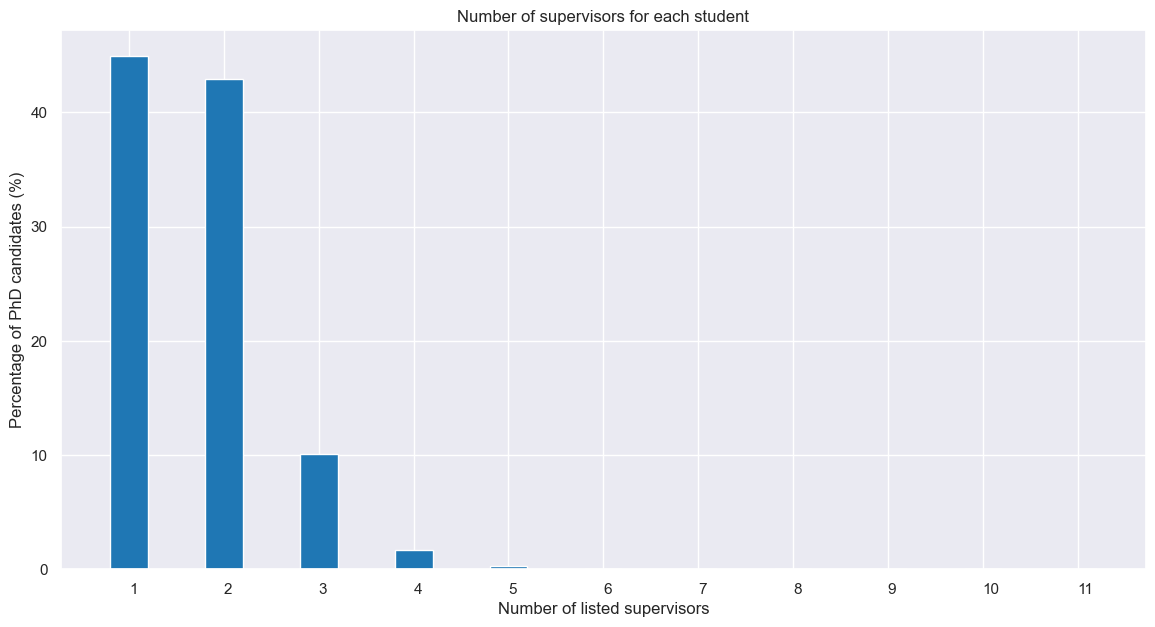

In [116]:
plt.bar(number_sups.value_counts().index, 100*number_sups.value_counts()/len(number_sups), 0.4)
plt.title("Number of supervisors for each student")
plt.xticks(range(1,12), range(1,12), ha='left')
plt.xlabel('Number of listed supervisors')
plt.ylabel("Percentage of PhD candidates (%)")
plt.show()

So most people have 1-3 supervisors, as we would expect, however some people have up to 11 (😱). This seems like a lot, but I've checked some of the cases and it seems that this is true according to the website, but when you pull off the pdfs typically only 3 are actual supervisors. One example:

In [117]:
all_sups.loc[number_sups == 11]
print(all_sups[43664])
print(df_supervisor['Author'][43664])

['Le Tissier, P.']
Cheung, L.


So how many supervisors supervise multiple students? 

In [118]:
supervision_count = [item for sublist in all_sups for item in sublist]
supervision_count = pd.Series(supervision_count).value_counts()
print(supervision_count)

Darzi, Ara            93
Woods, Kevin          88
Thompson, John        85
Neville, Anne         85
Bond, Caroline        82
                      ..
Farewell, Timothy      1
Nalianda, D.           1
Athanasios, Kolios     1
Muneer, Asif           1
Kennerley, Aneurin     1
Name: count, Length: 86087, dtype: int64


Wow! some people are notorious supervisors. Let's check out the main culprits: those with over 50 supervisions:


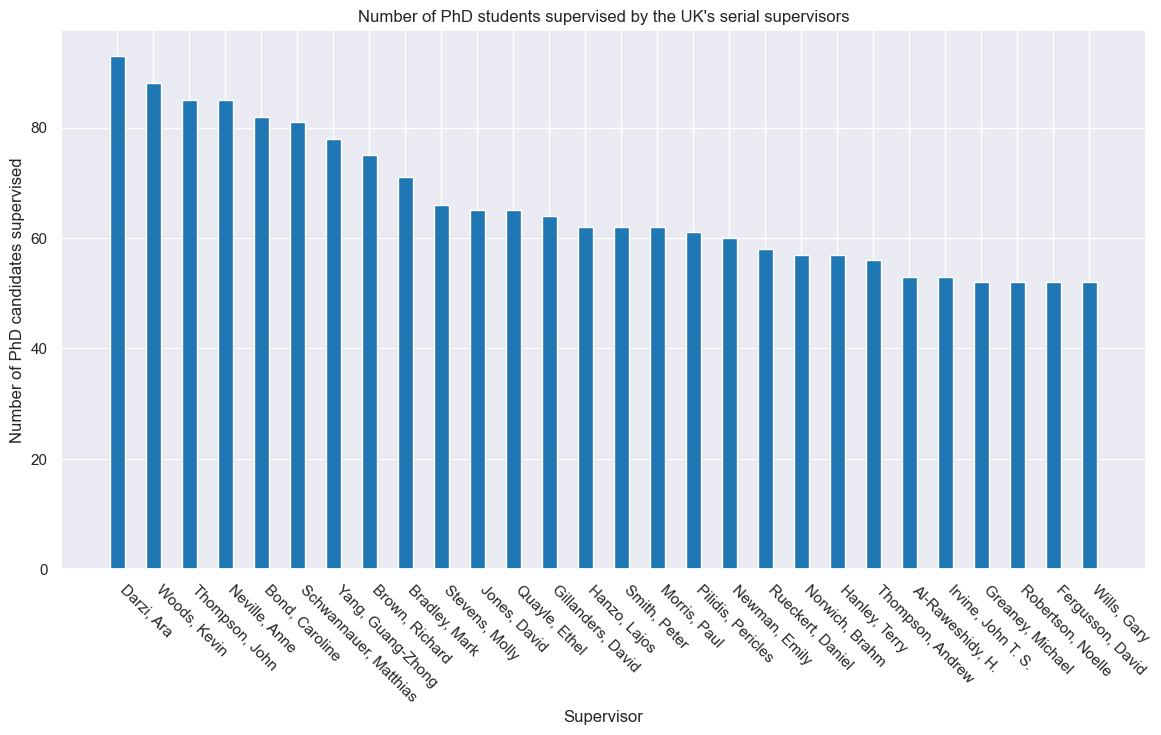

In [119]:
top_supervision_count = supervision_count.loc[supervision_count > 50]

plt.bar(top_supervision_count.index, top_supervision_count, 0.4)
plt.title("Number of PhD students supervised by the UK's serial supervisors")
plt.xticks(ha='left', rotation=-45)
plt.xlabel('Supervisor')
plt.ylabel("Number of PhD candidates supervised")
plt.show()

Obviously some of these may be multiple people with the same name, however a quick good search confirms that these are indeed well established researchers with large groups.

In [120]:
df.loc[df['Supervisor(s)'].str.contains('Neville, Anne')]

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL,Surname,Forenames,Firstname,Predicted_gender
263211,263211,Barium sulphate formation kinetics and inhibit...,,"Mavredaki, Eleftheria",https://isni.org/isni/000000042681706X,,University of Leeds,https://isni.org/isni/0000000419368403,2009,Thesis (Ph.D.),This study refers to experimental work and ana...,Engineering & Technology,"Neville, Anne",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/21106/,Mavredaki,Eleftheria,Eleftheria,Female
263212,263212,Erosion-corrosion of marine alloys,,"Meng, Hang",https://isni.org/isni/000000042681714X,,University of Leeds,https://isni.org/isni/0000000419368403,2009,Thesis (Ph.D.),"Marine alloys such as stainless steels, copper...",Engineering & Technology,"Neville, Anne ; Hu, Xinming",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/12739/,Meng,Hang,Hang,Androgynous
267908,267908,Erosion-corrosion mitigation using chemicals,,"Chun, Wang",https://isni.org/isni/0000000426852367,,University of Leeds,https://isni.org/isni/0000000419368403,2007,Thesis (Ph.D.),The presence of entrained sand in oil and gas ...,Engineering & Technology,"Neville, Anne",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/747/,Chun,Wang,Wang,Androgynous
283698,283698,The lubrication of aluminium-silicon surfaces ...,,"Burkinshaw, Michael Stephen",https://isni.org/isni/000000042697257X,,University of Leeds,https://isni.org/isni/0000000419368403,2010,Thesis (Ph.D.),Even though research into aluminium-silicon al...,Engineering & Technology,"Neville, Anne ; Morina, Ardian",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/21110/,Burkinshaw,Michael Stephen,Michael,Male
299946,299946,A novel electrochemical technique for mineral ...,,"Teh, Tong H.",https://isni.org/isni/0000000427121494,,Heriot-Watt University,https://isni.org/isni/0000000106567444,2011,Thesis (Ph.D.),Mineral scaling poses a far greater problem to...,Engineering & Technology,"Neville, Anne ; Thomson, Gillian",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://hdl.handle.net/10399/2488,Teh,Tong H.,Tong,Androgynous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607583,607583,Development of novel sensing solutions for coa...,,"Xu, Nan",https://isni.org/isni/0000000509705741,https://orcid.org/0000000282916519,University of Leeds,https://isni.org/isni/0000000419368403,2022,Thesis (Ph.D.),,Engineering & Technology,"Morina, Ardian ; Jose, Gin ; Neville, Anne",Engineering and Physical Sciences Research Cou...,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/31013/,Xu,Nan,Nan,Mostly_female
617262,617262,Engine oil contamination : causes and impact o...,,"Al Sheikh Omar, Alaaeddin",,,University of Leeds,https://isni.org/isni/0000000419368403,2022,Thesis (Ph.D.),"In recent years, there has been an increasing ...",,"Morina, Ardian ; Motamen Salehi, Farnaz ; Nevi...",EPSRC,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/31409/,Al Sheikh Omar,Alaaeddin,Alaaeddin,Unknown
617311,617311,Mucin layer behaviour and its role in dental t...,,"Smart, Pravin Alexander",,https://orcid.org/0000000207238236,University of Leeds,https://isni.org/isni/0000000419368403,2022,Thesis (Ph.D.),"Over the past few decades, the prevalence of t...",,"Bryant, Michael ; Neville, Anne",EPSRC,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/31657/,Smart,Pravin Alexander,Pravin,Unknown
619775,619775,Understanding the mechanisms by which molybden...,,"Barnes, Aaron Lynford",,https://orcid.org/0000000297595412,University of Leeds,https://isni.org/isni/0000000419368403,2021,Thesis (Ph.D.),,,"Morina, Ardian ; Neville, Anne ; Andrew, Rhiann",EPSRC ; Infineum UK Ltd,https://etho

---

# 3. Supervisor network analysis

Convert supervision to long format: 

In [121]:
df_supervisor.columns

Index(['index', 'Unnamed: 0', 'Title', 'DOI', 'Author', 'Author ISNI', 'ORCID',
       'Institution', 'Institution ISNI', 'Date', 'Qualification', 'Abstract',
       'Subject Discipline', 'Supervisor(s)', 'Funder(s)', 'EThOS URL',
       'IR URL', 'Surname', 'Forenames', 'Firstname', 'Predicted_gender'],
      dtype='object')

## How shall we deal with 

In [122]:
# Any identical titles
df_dups = df_supervisor['Title'].value_counts()


In [123]:
df_dups = df_dups[df_dups > 1]

print(df_dups)

Title
Doctorate in Clinical Psychology : main research portfolio                                                                25
Portfolio of compositions                                                                                                 22
Portfolio of original compositions                                                                                        21
Research portfolio submitted in part fulfilment of the requirements for the degree of Doctorate in Clinical Psychology    18
Essays in financial economics                                                                                             10
                                                                                                                          ..
Some problems in eigenfunction expansions                                                                                  2
Three essays in development economics                                                                                  

In [124]:
supervisor_network = pd.DataFrame([(k, y) for k, v in enumerate(all_sups) for y in v], columns=['type','Supervisor'])

supervisor_network['Author'] = df_supervisor['Author'][supervisor_network['type'].values].values
supervisor_network['Institution'] = df_supervisor['Institution'][supervisor_network['type'].values].values

supervisor_network['Title'] = df_supervisor['Title'][supervisor_network['type'].values].values
supervisor_network['Discipline'] = df_supervisor['Subject Discipline'][supervisor_network['type'].values].values
supervisor_network['Supervisor role'] = supervisor_network.groupby((supervisor_network['type'] != supervisor_network['type'].shift(1)).cumsum()).cumcount()+1

supervisor_network['Number of Supervisors'] = supervisor_network.groupby('Author')['Author'].transform('size')
supervisor_network['Number of Supervisees'] = supervisor_network.groupby('Supervisor')['Supervisor'].transform('size')

supervisor_network.head()

,type,Supervisor,Author,Institution,Title,Discipline,Supervisor role,Number of Supervisors,Number of Supervisees
0,0,"Rae, John","Robinson, Peter Clive",University of Oxford,"Connectivity, flow and transport in network mo...",Physical Sciences,1,1,17
1,1,"Trew, Karen","Gallagher, Anthony",Queen's University Belfast,Social identity and ideology in intergroup con...,"Philosophy, Psychology & Religious Studies",1,1,1
2,2,"Gough, Brendan","Day, Katy L.",Sheffield Hallam University,Women and alcohol : contemporary discourses ar...,"Social, Economic & Political Studies",1,3,4
3,2,"Mcfadden, Majella","Day, Katy L.",Sheffield Hallam University,Women and alcohol : contemporary discourses ar...,"Social, Economic & Political Studies",2,3,2
4,2,"Mac an Ghaill, Mairtin","Day, Katy L.",Sheffield Hallam University,Women and alcohol : contemporary discourses ar...,"Social, Economic & Political Studies",3,3,1


In [126]:
# Save this object
import pickle

supervisor_network.to_pickle('../Data/supervisor_data.pickle')

## 3.1 Same Name Issue

The issue with creating networks linked by name is that there are many individuals with the same name (e.g. David Jones). If we look at this in the author/student case, we would assume very few individuals have > 1 PhD. A little online scrolling suggests that of all PhD students < 1% have multiple doctorates (although no hard data on this). 

Perhaps we can individualise authors using their institution + discipline, however this is not really possible for the supervisors as they may have cross-discipline, inter-institution supervision. 


In [127]:
# Remove initialised first names
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in df['Firstname'] ]
df_dups = df.loc[s]


# Which names are duplicated?
df_dups = df_dups['Author'].value_counts()
df_dups = df_dups[df_dups > 1]

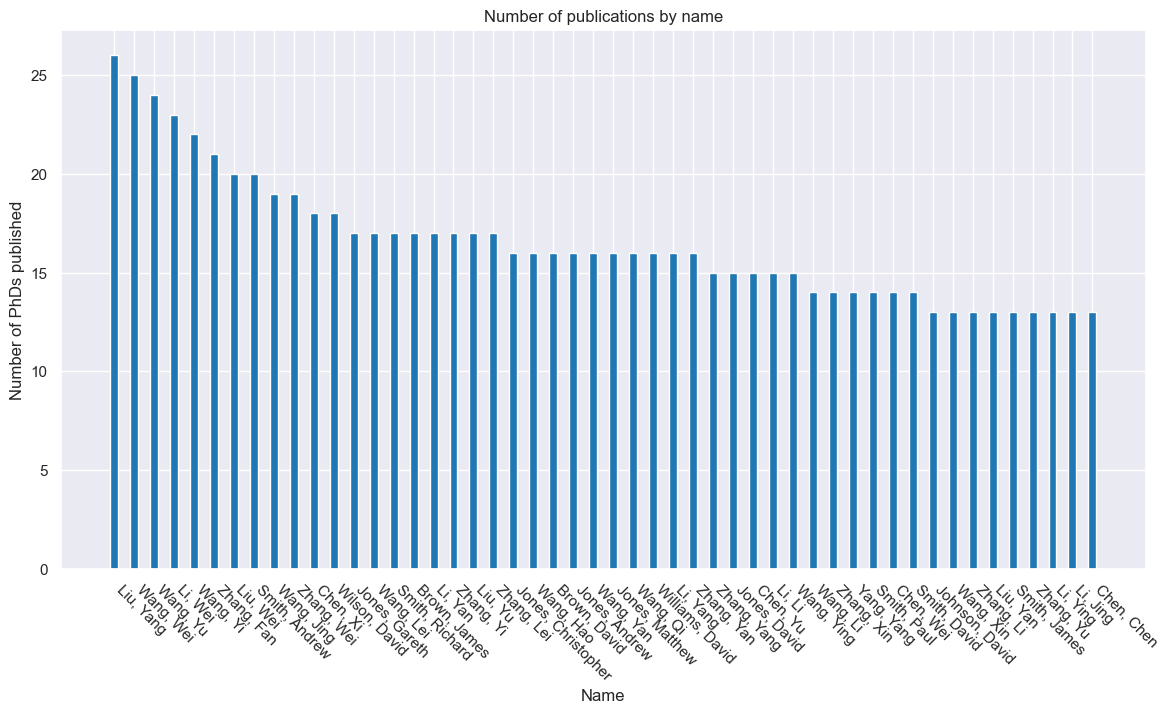

In [128]:
df_dups = df_dups.head(50)

X_axis = np.arange(len(df_dups))

# Percentages, by subject
plt.rc('axes', unicode_minus=False)
plt.bar(X_axis, df_dups, 0.4)
plt.title("Number of publications by name")
plt.xticks(X_axis, list(df_dups.index), rotation=-45, ha='left')
#plt.axhline(y = 50, color = 'black', linestyle = ':')
plt.xlabel("Name")
plt.ylabel("Number of PhDs published")
plt.show()

Even within institutions and disciplines names are not unique: 

In [129]:
# Get the duplicated authors with institution and discipline
name_count = df.loc[df['Author'].isin(df_dups.index), ['Author', 'Institution', 'Subject Discipline']].value_counts()
print(name_count)

print('\nNumber of publications for all name+institution+discipline combinations:')
name_count.value_counts()

Author      Institution                                       Subject Discipline      
Liu, Yang   Imperial College London                           Engineering & Technology    3
Wang, Jing  University of Nottingham                          Engineering & Technology    3
Wang, Yu    University of Manchester                                                      3
Liu, Yang   Loughborough University                           Engineering & Technology    2
Wang, Li    Loughborough University                           Engineering & Technology    2
                                                                                         ..
Liu, Wei    Swansea University                                Engineering & Technology    1
            University College London (University of London)  Engineering & Technology    1
                                                              Physical Sciences           1
            University of Bath                                Mathematics & Statistic

count
1    748
2     35
3      3
Name: count, dtype: int64

What about for the supervisors? Is it realistic to link them to institution? or discipline? or century? 

## 3.2 Creating a network

For now we are subsetting to author names who also supervise (and they supervise more than 1 student) in the field of medicine

In [130]:
sub_sup_network = supervisor_network[['Author', 'Supervisor', 'Discipline', 
                                        'Number of Supervisees', 'Supervisor role']]

# Only authors who also go on to supervise in medicine
sub_sup_network = sub_sup_network.loc[sub_sup_network['Author'].isin(sub_sup_network['Supervisor'])]
sub_sup_network = sub_sup_network.loc[sub_sup_network['Discipline'].isin(['Medicine & Health'])]

# Multiple supervisees
sub_sup_network = sub_sup_network.loc[sub_sup_network['Number of Supervisees'] > 1]

print(supervisor_network.shape[0], sub_sup_network.shape[0])

259848 1827


Set up the network

In [131]:
plt.rcParams['figure.figsize'] = [12, 12]

G = nx.DiGraph()

for  i, (x, y, sub, sup_n, sup_role) in sub_sup_network.head(100).iterrows():
    G.add_node(x, color='red',style='filled',fillcolor='blue',shape='square')
    G.add_node(y, color='red',style='filled',fillcolor='blue',shape='square')
    G.add_edge(x,y)

In [132]:
# Discretise a continuous colour scale
from plotly.express.colors import sample_colorscale
from sklearn.preprocessing import minmax_scale

colors_ = list(range(1, 12))
discrete_colors = sample_colorscale('Bluered', minmax_scale(colors_))


In [133]:
print(discrete_colors)

['rgb(0, 0, 255)', 'rgb(26, 0, 230)', 'rgb(51, 0, 204)', 'rgb(77, 0, 178)', 'rgb(102, 0, 153)', 'rgb(128, 0, 127)', 'rgb(153, 0, 102)', 'rgb(179, 0, 76)', 'rgb(204, 0, 51)', 'rgb(230, 0, 25)', 'rgb(255, 0, 0)']


In [134]:
#discrete_colors[0].convert("RGBA")

In [135]:
#sub_sup_network.head()
order = [sub_sup_network['Supervisor role'].head(100).values -1] 

edge_cols = [discrete_colors[i] for i in order[0]]

Visualise the network (this can take some time for many nodes)

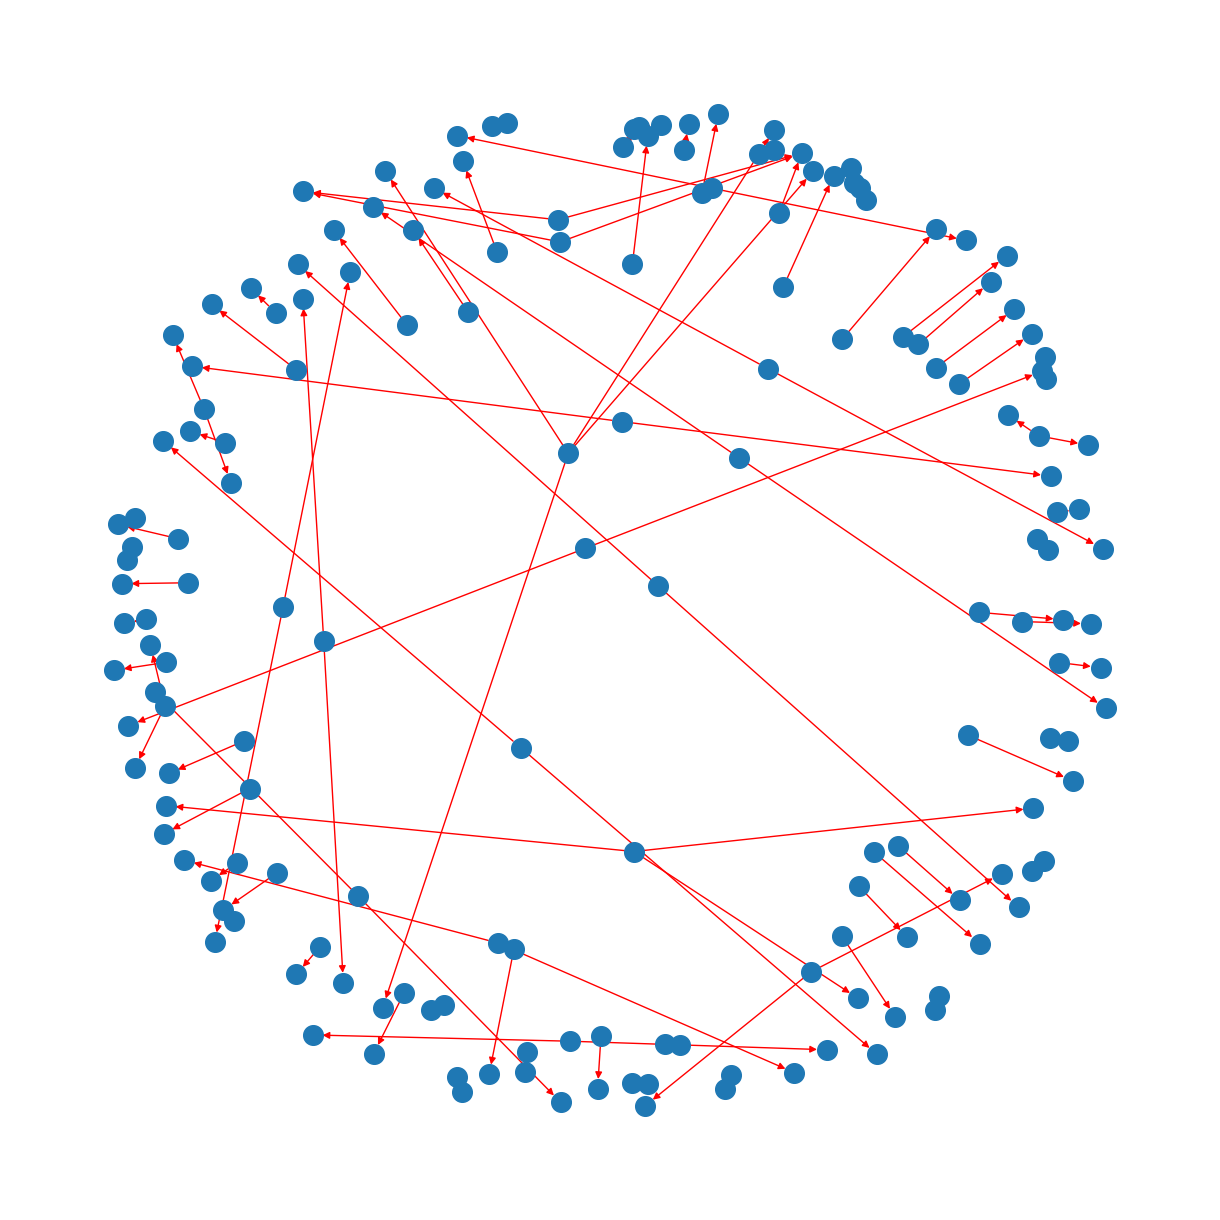

In [136]:
nx.draw_spring(G, with_labels = False, font_size=14 , 
                node_size=200, edge_color='red')

What about if we try plotting with plotly

In [137]:
pos = nx.spring_layout(G)

In [138]:
# Set up the edges
def make_edge(x, y, text, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       #text      = ([text]),
                       mode      = 'lines')

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in G.edges():  
  
    char_1 = edge[0]
    char_2 = edge[1]
    x0, y0 = pos[char_1]
    x1, y1 = pos[char_2]
    text   = char_1 + '--' + char_2 + ': '# + str(G.edges()[edge]['weight'])
        
    trace  = make_edge([x0, x1, None], [y0, y1, None], text, width=1)#, 
                        #width = 0.3*G.edges()[edge]['weight']**1.75)
    edge_trace.append(trace)

In [139]:
# Set up the nodes
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 10,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node in midsummer, get the position and size and add to the node_trace
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([1])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

In [140]:
# Customize layout
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)
# Create figure
fig = go.Figure(layout = layout)
# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
# Add node trace
fig.add_trace(node_trace)
# Remove legend
fig.update_layout(showlegend = False)
# Remove tick labels
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
# Show figure
fig.show()

---

# 4. Reiterate the duplicated names problem

In [142]:
supervisor_network['Surname'] = supervisor_network.apply(lambda row : row['Supervisor'].split(",")[0].strip(), axis = 1)
supervisor_network['Forenames'] = supervisor_network.apply(lambda row : re.sub(".*,", "", str(row['Supervisor'])), axis = 1)
supervisor_network['Firstname'] = supervisor_network.apply(lambda row : row['Forenames'].strip().split(" ")[0].strip(), axis = 1)

In [143]:
supervisor_network[['Author', 'Supervisor', 'Surname', 'Firstname']].head()

,Author,Supervisor,Surname,Firstname
0,"Robinson, Peter Clive","Rae, John",Rae,John
1,"Gallagher, Anthony","Trew, Karen",Trew,Karen
2,"Day, Katy L.","Gough, Brendan",Gough,Brendan
3,"Day, Katy L.","Mcfadden, Majella",Mcfadden,Majella
4,"Day, Katy L.","Mac an Ghaill, Mairtin",Mac an Ghaill,Mairtin


In [144]:
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in supervisor_network['Firstname'] ]
df_dups = supervisor_network.loc[s]


# Which names are duplicated?
df_dups = df_dups['Supervisor'].value_counts()
df_dups = df_dups[df_dups > 1]

In [145]:
df_dups.index

Index(['Darzi, Ara', 'Woods, Kevin', 'Neville, Anne', 'Thompson, John',
       'Bond, Caroline', 'Schwannauer, Matthias', 'Yang, Guang-Zhong',
       'Brown, Richard', 'Bradley, Mark', 'Stevens, Molly',
       ...
       'Lee, Min', 'Rimmel, Gunnar', 'Hutt, Corinne', 'Shaw, Liz',
       'Rentfrow, Jason', 'Cook, Jonathan', 'Fooks, Gary', 'Allen, Sheila',
       'Pearsall, Sarah', 'Kelly, Paul H. J.'],
      dtype='object', name='Supervisor', length=36559)

In [146]:
# Get the duplicated authors with institution and discipline
name_count = supervisor_network.loc[supervisor_network['Supervisor'].isin(df_dups.index), 
                                    ['Supervisor', 'Institution']].value_counts()
print(name_count.tail(20))

Supervisor              Institution             
Sullivan, Mark          University of Portsmouth    1
Jackson, Martin         Imperial College London     1
Kirkby, Norman          University of Surrey        1
Arnold, John            University of Manchester    1
Ponting, Christopher    University of Edinburgh     1
Vincent, Nigel          University of Hull          1
Scott-Bottoms, Stephen  University of Leeds         1
Kirkby, Norman          University of Manchester    1
Fox, Keith              University of Edinburgh     1
Vincent, Katy           University of Edinburgh     1
Arnold, Polly L.        University of Edinburgh     1
Millar, Ian             Lancaster University        1
Vincent, Julian         Heriot-Watt University      1
Vincent, John           University of Oxford        1
                        Keele University            1
Millar, Ian             University of Oxford        1
Butler, Ian             Keele University            1
Kirkby, Karen           Universit

In [147]:
temp = supervisor_network[['Supervisor', 'Institution']]
temp['both'] = temp['Supervisor'] + temp['Institution']

ids_auth_and_inst = temp['both'].value_counts()
ids_auth_only = temp['Supervisor'].value_counts()

temp['inst_and_auth'] = temp.groupby('both')['both'].transform('size')
temp['auth_only'] = temp.groupby('Supervisor')['Supervisor'].transform('size')

temp.head()

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_64396/128647059.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_64396/128647059.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_64396/128647059.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,Supervisor,Institution,both,inst_and_auth,auth_only
0,"Rae, John",University of Oxford,"Rae, JohnUniversity of Oxford",1,17
1,"Trew, Karen",Queen's University Belfast,"Trew, KarenQueen's University Belfast",1,1
2,"Gough, Brendan",Sheffield Hallam University,"Gough, BrendanSheffield Hallam University",2,4
3,"Mcfadden, Majella",Sheffield Hallam University,"Mcfadden, MajellaSheffield Hallam University",2,2
4,"Mac an Ghaill, Mairtin",Sheffield Hallam University,"Mac an Ghaill, MairtinSheffield Hallam University",1,1


In [148]:
temp2 = temp.loc[temp['auth_only'] != temp['inst_and_auth']]

temp2.shape[0]

38565

But we can't really class these as unique (as we could for authors) since supervisors could legitimately change institution or supervised students from other institutions e.g. Sallie Lamb: 

In [149]:
supervisor_network.loc[supervisor_network['Supervisor'].str.contains('|'.join(['Lamb, Sallie']))]

,type,Supervisor,Author,Institution,Title,Discipline,Supervisor role,Number of Supervisors,Number of Supervisees,Surname,Forenames,Firstname
4956,3704,"Lamb, Sallie","Barker, Karen L.",Oxford Brookes University,The effect of leg lengthening surgery on muscl...,Medicine & Health,1,1,2,Lamb,Sallie,Sallie
127528,80320,"Lamb, Sallie","Jayakumar, Prakash",University of Oxford,Patient reported outcome (PRO) measurement of ...,Medicine & Health,3,4,2,Lamb,Sallie,Sallie


Note that here it doesn't seem to be as much of an issue as for the authors

---

# 4. Supervisor gender analysis

In [151]:
supervisor_network['Predicted_gender'] = supervisor_network.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
gender_count = supervisor_network.Predicted_gender.value_counts()

print(gender_count)

Predicted_gender
male             145248
female            53527
unknown           49591
mostly_male        4780
andy               3518
mostly_female      3184
Name: count, dtype: int64


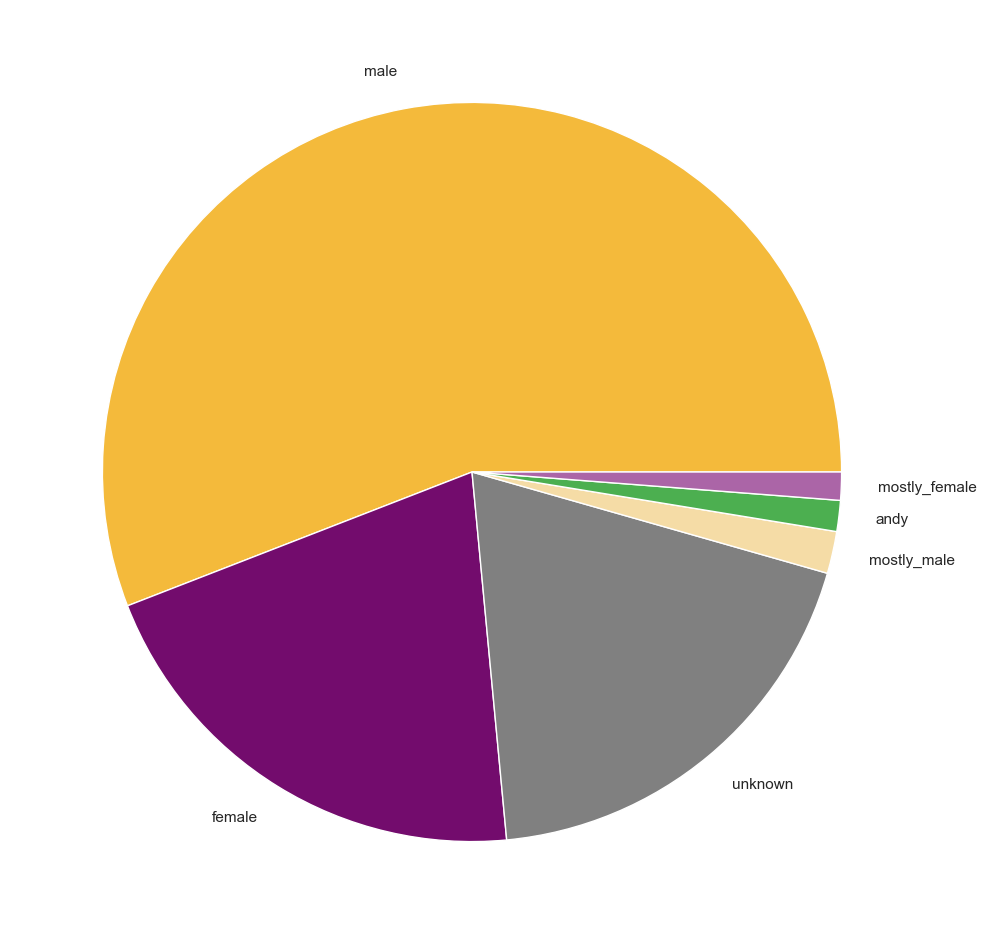

In [152]:
colours = {'unknown': 'grey', 'andy': '#4CAF50', 
            'female': '#730C6D', 'male': '#F4BA3B', 
            'mostly_female': '#ab65a7', 'mostly_male': '#f5dca6'}
colours = pd.Series(data=colours, index=list(gender_count.index))
            
plt.pie(gender_count, labels = list(gender_count.index), colors=colours)
plt.show() 

How does this break down by supervision role? 

In [153]:
df2 = supervisor_network

all_subject = df2['Supervisor role'].value_counts()
all_subject = all_subject.reindex(list(range(1, 12)))
male = df2.loc[df2["Predicted_gender"].isin(["male"])]['Supervisor role'].value_counts().reindex(list(range(1, 12)))
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(list(range(1, 12)))
male = male.reindex(list(range(1, 12)))
female = df2.loc[df2["Predicted_gender"].isin(["female"])]['Supervisor role'].value_counts().reindex(list(range(1, 12)))

female = female.fillna(0)


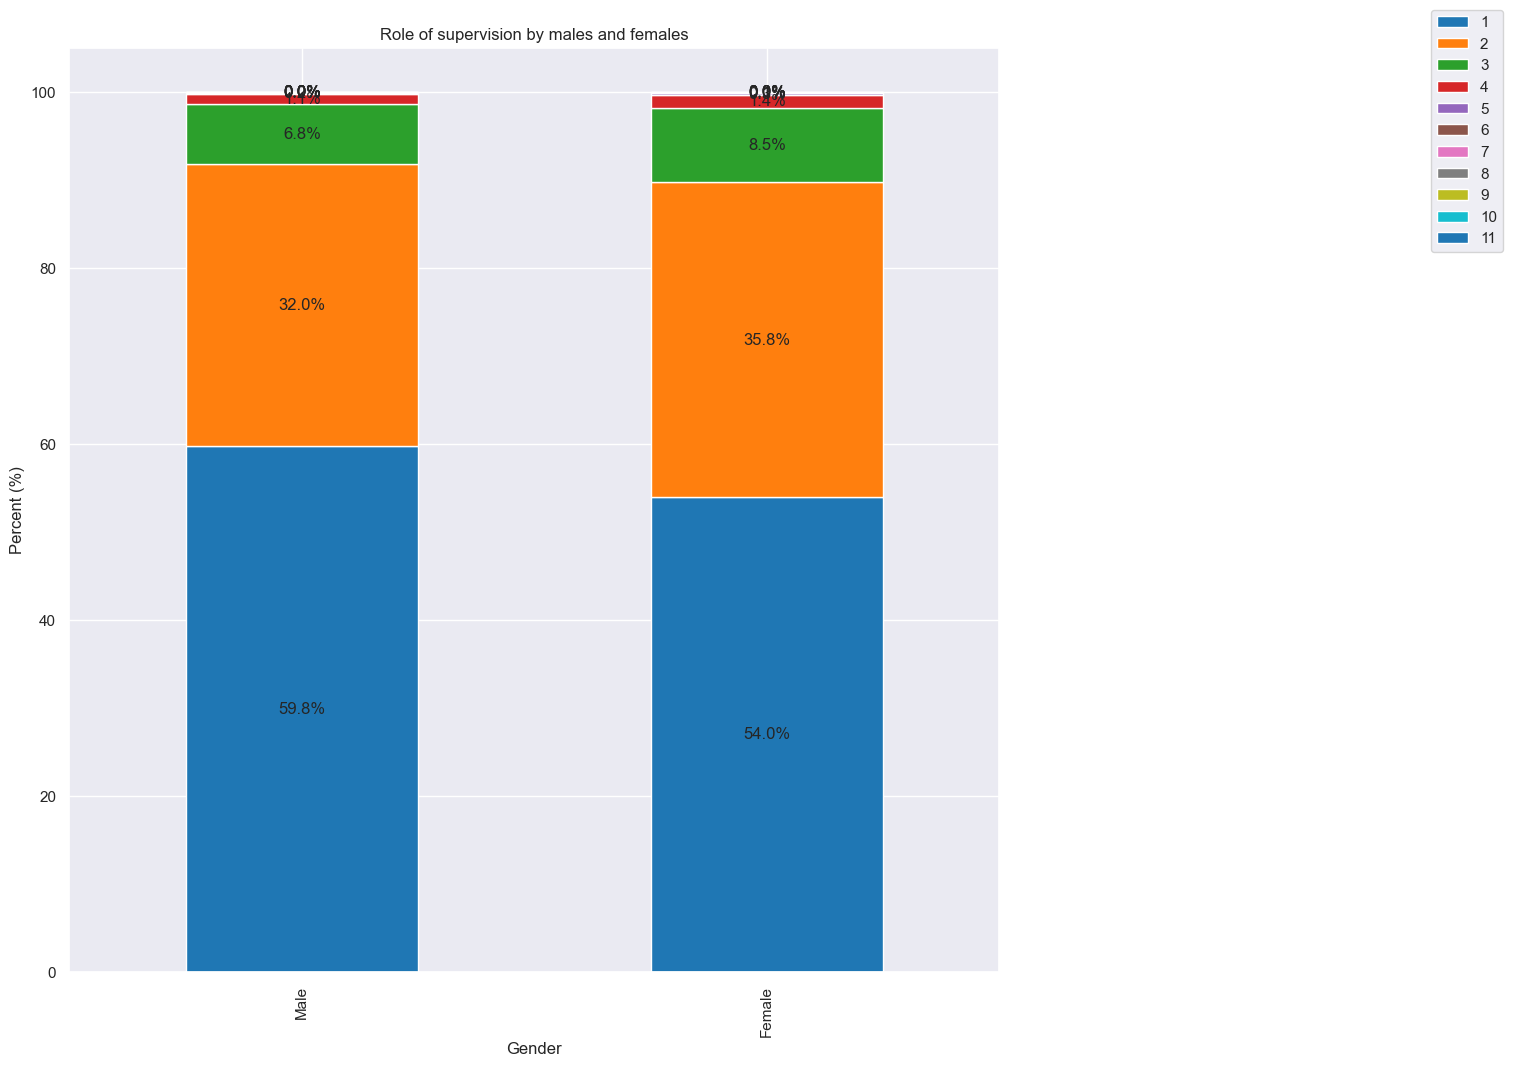

In [154]:
cols = ['Gender']
cols.extend(range(1, 12))

df_role = pd.DataFrame(columns=cols)

m = ['Male']
m.extend(100*male.values/sum(male))
f = ['Female']
f.extend(100*female.values/sum(female))

df_role.loc[len(df_role)] = m
df_role.loc[len(df_role)] = f

ax = df_role.plot.bar(x='Gender', stacked='True', ylabel='Percent (%)')
ax.legend(bbox_to_anchor=(1.55, 1.05))
ax.set_title('Role of supervision by males and females')

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [str(round(v.get_height(), 1)) + "%" if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')



Females slightly less likely to be first supervisors and more are 2nd or 3rd supervisors

---

# Concluding Remarks

Here we have explored the gender breakdown

## Known Issues

- Here we are only including authors who provide first names. However women are more likely to initialize their names to mask gender. Additionally, this ratio varies between disciplines. 

- Some names not found by `gender_guesser`

- When counting, some names may not be unique (e.g. David Jones supervises > 50 students), however these may be multiple david jones'. Solution might be to group by institution but we dont necessarily know the supervisor inst. only the student ones. 

- Some supervisors I suspect are incorrectly assigned (especially for those with > 11)

- Assuming nobofy changes there name


## Data set not complete

- We have found anecdotal examples (Isabel's supervisor for example)



## To Do
- [ ] Try predicting gender with [nltk](https://www.geeksforgeeks.org/python-gender-identification-by-name-using-nltk/)
- [ ] Think about how yo handle non-unique names



- [ ] Could we use the abstract NLP to determine whether supervisors with same name are same person? 



- [ ] supervisor disambigation from abstract similarity? 


Author/supervisor disambigation

- [ ] does Jack Good student  == Jack Good supervisor

- [ ] cut-off on year (PhD thesis year should be before supervision year) and within in a realistic lifetime

- [ ] Then text similarity embedding comparison (see the slack channel for starting point) - see how similar theses abstracts/titles are (ignore those below a certain threshold). Then we should get a score for how likely people are to be the same person